In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
df = pd.read_csv("/content/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

In [5]:
# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [6]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [7]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1  
        elif i == 8: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

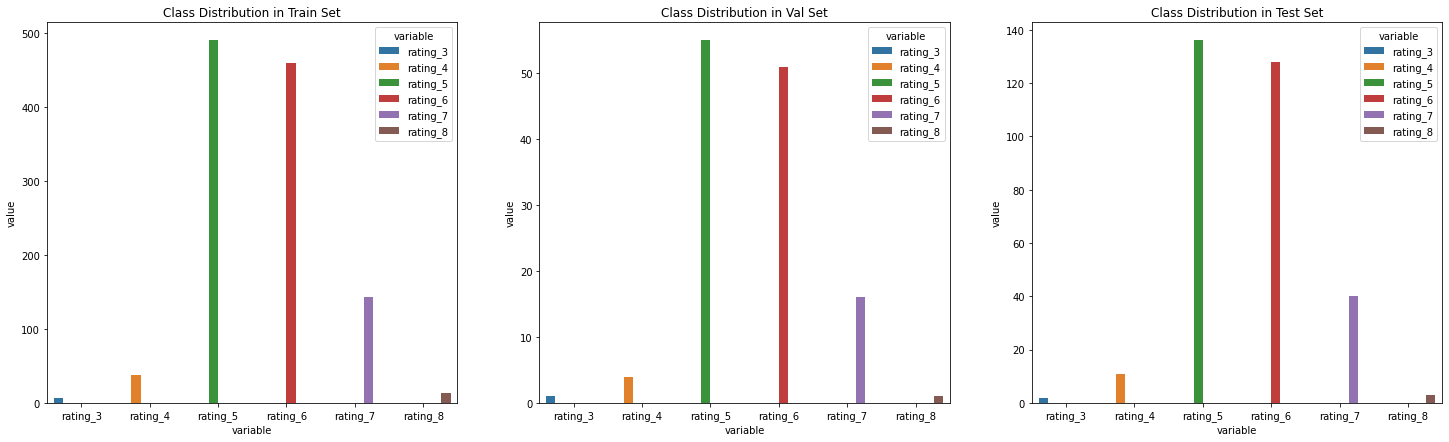

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Val
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [9]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [10]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [11]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [13]:
class MultipleRegression(nn.Module):
  def __init__(self, num_features):
    super(MultipleRegression, self).__init__()
        
    self.layer_1 = nn.Linear(num_features, 16)
    self.layer_2 = nn.Linear(16, 32)
    self.layer_3 = nn.Linear(32, 16)
    self.layer_out = nn.Linear(16, 1)
        
    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.relu(self.layer_1(inputs))
    x = self.relu(self.layer_2(x))
    x = self.relu(self.layer_3(x))
    x = self.layer_out(x)
    return (x)

  def predict(self, test_inputs):
    x = self.relu(self.layer_1(test_inputs))
    x = self.relu(self.layer_2(x))
    x = self.relu(self.layer_3(x))
    x = self.layer_out(x)
    return (x)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [16]:
loss_stats = {
    'train': [],
    "val": []
}

In [33]:
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    
for X_train_batch, y_train_batch in train_loader:
  X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
  optimizer.zero_grad()
        
  y_train_pred = model(X_train_batch)
        
  train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
  train_loss.backward()
  optimizer.step()
        
  train_epoch_loss += train_loss.item()
        
        
# VALIDATION    
with torch.no_grad():
  val_epoch_loss = 0
        
  model.eval()
  for X_val_batch, y_val_batch in val_loader:
    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
    y_val_pred = model(X_val_batch)
    val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
    val_epoch_loss += val_loss.item()
loss_stats['train'].append(train_epoch_loss/len(train_loader))
loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 150: | Train Loss: 1.14529 | Val Loss: 1.06979


In [34]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

In [35]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [36]:
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)

print("Mean Squared Error :",mse)

Mean Squared Error : 0.9399138319386247
